# Tweets sentiment analysis with RNN

Using spacy tokenizer and embedding + LSTM for sentiment analysis

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import tensorflow as tf
import itertools as it
import pandas as pd
import spacy
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import optuna
import pprint
import logging
import matplotlib.pyplot as plt
import seaborn as sns

SCRIPT_NAME = 'E-RNN-embeddings-v1'

In [2]:
spacy_lang = spacy.load("en_core_web_md")

In [3]:
def spacy_tokenizer(sentence):
    return [(w.text,w.has_vector) for w in spacy_lang(sentence)]

def spacy_embedding(sentence, max_len=100):
    """Returns tuple (embedding, all tokens)"""
    embeddings = []
    tokens = spacy_lang(sentence)[:max_len]
    for token in tokens:
        if token.has_vector:
            embeddings.append(token.vector / token.vector_norm)
    return (embeddings, tokens)

def spacy_example():
    example2 = 'Don''t you expect this? Check out 123 page at http://simple.com/site/page.html and #others fyi @fellow'
    embeddings, tokens = spacy_embedding(example2)
    print(f'Known ratio: {len(embeddings)/len(tokens):.3f}')

EMBEDDING_DIM = spacy_lang("word")[0].vector.shape[0]
MAX_SEQ_LEN = 100
print(f'Vector embedding dim: {EMBEDDING_DIM}')
spacy_example()

Vector embedding dim: 300
Known ratio: 0.882


### Load and prepare train/validation data and find embeddings

In [4]:
df = pd.read_csv('train.csv')
X = df['text'].fillna('')
Y = df['target']

In [5]:
def preprocess(X):
    cnt_embeddings = 0
    cnt_tokens = 0
    x_embeddings = np.zeros((X.size, MAX_SEQ_LEN, EMBEDDING_DIM))

    for i, sentence in enumerate(X):
        embeddings, tokens = spacy_embedding(sentence, MAX_SEQ_LEN)
        cnt_embeddings += len(embeddings)
        cnt_tokens += len(tokens)
        for j, vector in enumerate(embeddings):
            x_embeddings[i, j] = vector

    print(f'All tokens: {cnt_tokens}, found embeddings: {cnt_embeddings}. Known tokens ratio: {cnt_embeddings/cnt_tokens:.3f}')
    print(f'Vector dim: {len(x_embeddings[0][0])}')

    return x_embeddings

In [6]:
X = preprocess(X)

All tokens: 135383, found embeddings: 122020. Known tokens ratio: 0.901
Vector dim: 300


In [18]:
X[:5,:20,:1]

array([[[ 0.03520362],
        [-0.03125338],
        [-0.08001059],
        [-0.07057038],
        [-0.04518668],
        [-0.10477114],
        [ 0.04174236],
        [ 0.06828009],
        [-0.01538143],
        [-0.04672509],
        [-0.00320503],
        [ 0.08226046],
        [ 0.03549374],
        [-0.03070577],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]],

       [[-0.10963316],
        [-0.06716903],
        [ 0.02251171],
        [-0.01168874],
        [-0.06093776],
        [-0.08387914],
        [-0.00127615],
        [-0.0549563 ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]],

       [[-0.05145295],
        [-0.04860586],
        [ 0.02808128],
       

### Split into train and validation data sets

In [8]:
X_train, X_dev, Y_train, Y_dev = train_test_split(X, Y, test_size=0.1, shuffle=True)

print(X_train.shape, Y_train.shape, X_dev.shape, Y_dev.shape)


(6851, 100, 300) (6851,) (762, 100, 300) (762,)


### Define model

In [19]:
def create_model(input_size, lstm_size, dense_size, dropout_1=0.5, dropout_2=0.5,
          learning_rate=1e-3):
    model = tf.keras.Sequential([
        # tf.keras.layers.Input(shape=(MAX_SEQ_LEN, input_size), dtype='float32'),
        tf.keras.layers.Masking(mask_value=0, input_shape=(None, input_size)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_size, dropout=dropout_1)),
        # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_size, dropout=dropout_2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(dense_size),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [20]:
def evaluate(X, Y, model):
    Y_predict = model.predict(X)
    Y_predict = (Y_predict > .5).astype(np.int8)
    f1_value = f1_score(Y, Y_predict)
    return Y_predict, f1_value


In [21]:
def train(X_train, Y_train, X_dev, Y, model, batch_size=32, max_epochs=4):
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
    
    model.fit(X_train, Y_train, batch_size=batch_size, epochs=max_epochs, 
            validation_data=(X_dev, Y),
            callbacks=[early_stopping],
            verbose=1)

    _, f1_value = evaluate(X_dev, Y, model)    

    print(f"Validation F1 score: {f1_value}")

    return f1_value

### Check model

In [22]:
model = create_model(EMBEDDING_DIM, lstm_size=8, dense_size=8)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_1 (Masking)         (None, None, 300)         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 16)               19776     
 nal)                                                            
                                                                 
 batch_normalization_2 (Batc  (None, 16)               64        
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 batch_normalization_3 (Batc  (None, 8)                32        
 hNormalization)                                                 
                                                      

In [13]:
X_train.shape, Y.shape, (MAX_SEQ_LEN, EMBEDDING_DIM)

((6851, 100, 300), (7613,), (100, 300))

In [14]:
X_train = X_train.astype('float32')
Y_train = Y_train.astype('float32')
X_dev = X_dev.astype('float32')
Y_dev = Y_dev.astype('float32')

In [15]:
train(X_train, Y_train, X_dev, Y_dev, model, max_epochs=5)

24/24 [==============================] - 2s 12ms/step
Validation F1 score: 0.7216494845360825


0.7216494845360825

### Define objective function

In [23]:
def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-3, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    lstm_size = trial.suggest_categorical('lstm_size', [4, 8, 16, 32, 64, 128])
    dense_size = trial.suggest_categorical('dense_size', [8, 16, 32, 64, 128, 256])
    use_dropout_1 = trial.suggest_categorical('use_dropout_1', [False, True])
    use_dropout_2 = False # trial.suggest_categorical('use_dropout_2', [False, True])
    if use_dropout_1:
        dropout_1 = trial.suggest_float('dropout_1', 0.1, 0.7)
    else:
        dropout_1 = 0
    if use_dropout_2:
        dropout_2 = trial.suggest_float('dropout_2', 0.1, 0.7)
    else:
        dropout_2 = 0

    model = create_model(input_size=EMBEDDING_DIM, lstm_size=lstm_size, dense_size=dense_size,
                  dropout_1=dropout_1, dropout_2=dropout_2, 
                  learning_rate=learning_rate)
    f1_score = train(X_train, Y_train, X_dev, Y_dev, model, 
                        batch_size=batch_size)
    
    trial.set_user_attr("model", model)
    
    return f1_score


In [24]:
def train_test():
    # Dummy input
    input_size = EMBEDDING_DIM  # Example feature size
    lstm_size = 64
    dense_size = 32
    batch_size = 1  # Small batch size for testing

    model = create_model(input_size, lstm_size, dense_size)
    # dummy_input = np.random.rand(batch_size, MAX_SEQ_LEN, input_size).astype('float32')
    # try:
    #     model.predict(dummy_input)
    #     print("Model accepted the input!")
    # except Exception as e:
    #     print("Error during model prediction:", e)

# train_test()

In [25]:
the_best_model = None

def save_best_model(study, trial):
    global the_best_model
    if study.best_trial.number == trial.number:
        # Save the model
        the_best_model = trial.user_attrs['model']

In [26]:
from optuna.visualization import plot_optimization_history, plot_slice

study = optuna.create_study(study_name=SCRIPT_NAME, direction='maximize')

[I 2024-05-07 09:50:04,810] A new study created in memory with name: E-RNN-embeddings-v1


In [27]:
study.optimize(objective, n_trials=10, callbacks=[save_best_model], show_progress_bar=True)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/4
215/215 [==============================] - 29s 116ms/step - loss: 0.5179 - accuracy: 0.7535 - val_loss: 0.6031 - val_accuracy: 0.7782
Epoch 2/4
215/215 [==============================] - 28s 131ms/step - loss: 0.4601 - accuracy: 0.7863 - val_loss: 0.5115 - val_accuracy: 0.7782
Epoch 3/4
215/215 [==============================] - 25s 116ms/step - loss: 0.4444 - accuracy: 0.7975 - val_loss: 0.4668 - val_accuracy: 0.7769
Epoch 4/4
24/24 [==============================] - 2s 28ms/step
Validation F1 score: 0.747068676716918
[I 2024-05-07 09:52:01,348] Trial 0 finished with value: 0.747068676716918 and parameters: {'learning_rate': 0.0004508413752731832, 'batch_size': 32, 'lstm_size': 128, 'dense_size': 128, 'use_dropout_1': True, 'dropout_1': 0.429306748919405}. Best is trial 0 with value: 0.747068676716918.
Epoch 1/4
429/429 [==============================] - 29s 58ms/step - loss: 0.5450 - accuracy: 0.7235 - val_loss: 0.5467 - val_accuracy: 0.7756
Epoch 2/4
429/429 [=============

In [28]:
trial = study.best_trial
print(f'-> Best score: {trial.value}')
print(f'-> Optimal network parameters: ')
pprint.pprint(trial.params)
print(f'-> Best learning parameters: ')
pprint.pprint(trial.user_attrs)


-> Best score: 0.7483660130718954
-> Optimal network parameters: 
{'batch_size': 8,
 'dense_size': 16,
 'learning_rate': 0.0007811554698497768,
 'lstm_size': 32,
 'use_dropout_1': False}
-> Best learning parameters: 
{'model': <keras.engine.sequential.Sequential object at 0x7f49d160cb90>}


In [29]:
def evaluate_final_results(X, Y, Y_pred):
    # Compute the confusion matrix
    cm = confusion_matrix(Y, Y_pred)

    # Compute other metrics
    accuracy = accuracy_score(Y, Y_pred)
    precision = precision_score(Y, Y_pred, average='macro')
    recall = recall_score(Y, Y_pred, average='macro')
    f1 = f1_score(Y, Y_pred, average='macro')

    # Print the metrics
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    # Plot the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()    

24/24 [==============================] - 1s 9ms/step
Accuracy: 0.7979002624671916
Precision: 0.8014442035794349
Recall: 0.7855966241649786
F1 Score: 0.7897531819745442


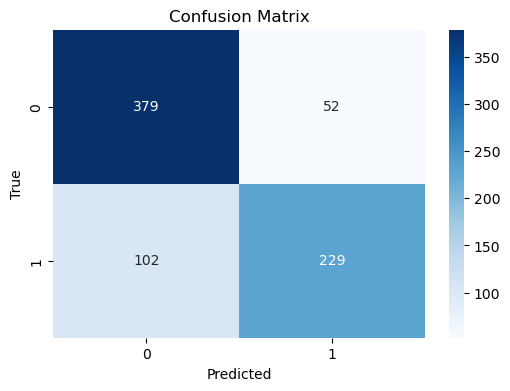

In [30]:
Y_predict, f1_value = evaluate(X_dev, Y_dev, the_best_model)
evaluate_final_results(X_dev, Y_dev, Y_predict)